# Team Project Spotify Popular Song
> Date: 09/24/2023
> Group 7: Arya Shahbazi and Ravita Kartawinata



### About:
Project: Predict Song Popularity 
Background: The dataset consists of insightful song attributes such as artists, song features, release date and chart from other platforms which would be used to predict a song’s success or popularity. The features can be used to identify pattern of popular audio features or identify song’s popularity across the platforms or identify artists involvement to the success of the song.

### Library and Dataset

In [2]:
import pandas as pd
import numpy as np
from statistics import mode, mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score


import matplotlib.pylab as plt
import seaborn as sns


from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

%matplotlib inline

In [3]:
# Load the data
data = pd.read_csv("C:/Users/rkartawi/Desktop/Ravita/MSADS/505/Project/spotify-2023.csv", encoding='ISO-8859-1')
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

### Data Preprocessing

In [4]:
#Check Missing Values

for col in data.columns:
    count = data[col].isnull().sum()
    if count > 0:
        print(f"Column: {col}, Count of 'Null': {count}")


Column: in_shazam_charts, Count of 'Null': 50
Column: key, Count of 'Null': 95


In [5]:
# drop missing key value and replace in_shazam_chart nan with 0
data = data.dropna(subset=['key'])
data['in_shazam_charts'] = data['in_shazam_charts'].fillna(0)

### Data Visualization

In [6]:
# bin similiar columns
tune = ['bpm', 'danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 
                  'instrumentalness_%', 'liveness_%', 'speechiness_%']

list_chart = ['streams', 'in_spotify_playlists', 'in_spotify_charts', 
              'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 
              'in_deezer_charts', 'in_shazam_charts']

data['solo'] = data['artist_count'].apply(lambda x: 0 if x > 1 else 1)

top_chart = ['artist(s)_name', 'solo', 'key', 'released_year', 'released_month']
# data.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,solo
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,0
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,1
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,1
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,A,Major,55,58,72,11,0,11,15,1
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,A,Minor,65,23,80,14,63,11,6,1


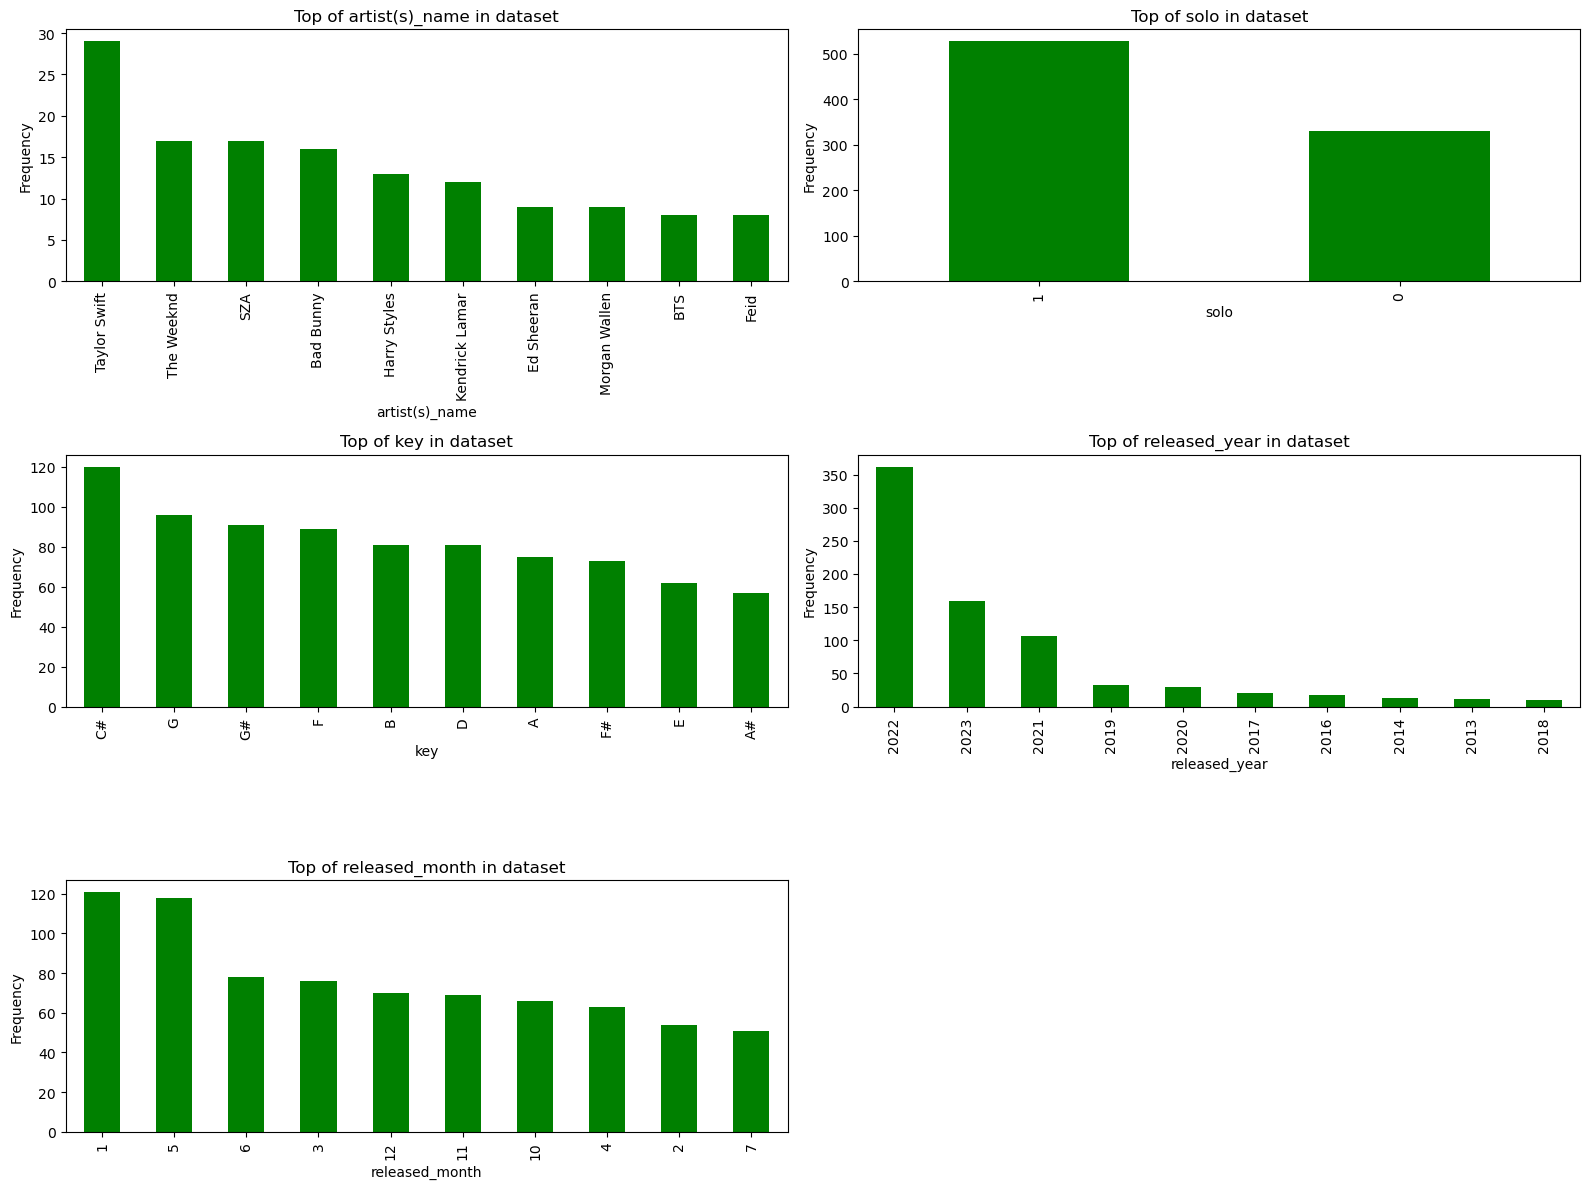

In [7]:
# top song feature
plt.figure(figsize=(16, 12))
top_n = 10
for i, col in enumerate(top_chart, 1):
    plt.subplot(3, 2, i)
    data_count = data[col].value_counts()
    top_data = data_count.head(top_n)
    top_data.plot(kind='bar', color='green')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Top of {col} in dataset")
    plt.tight_layout()
plt.show()

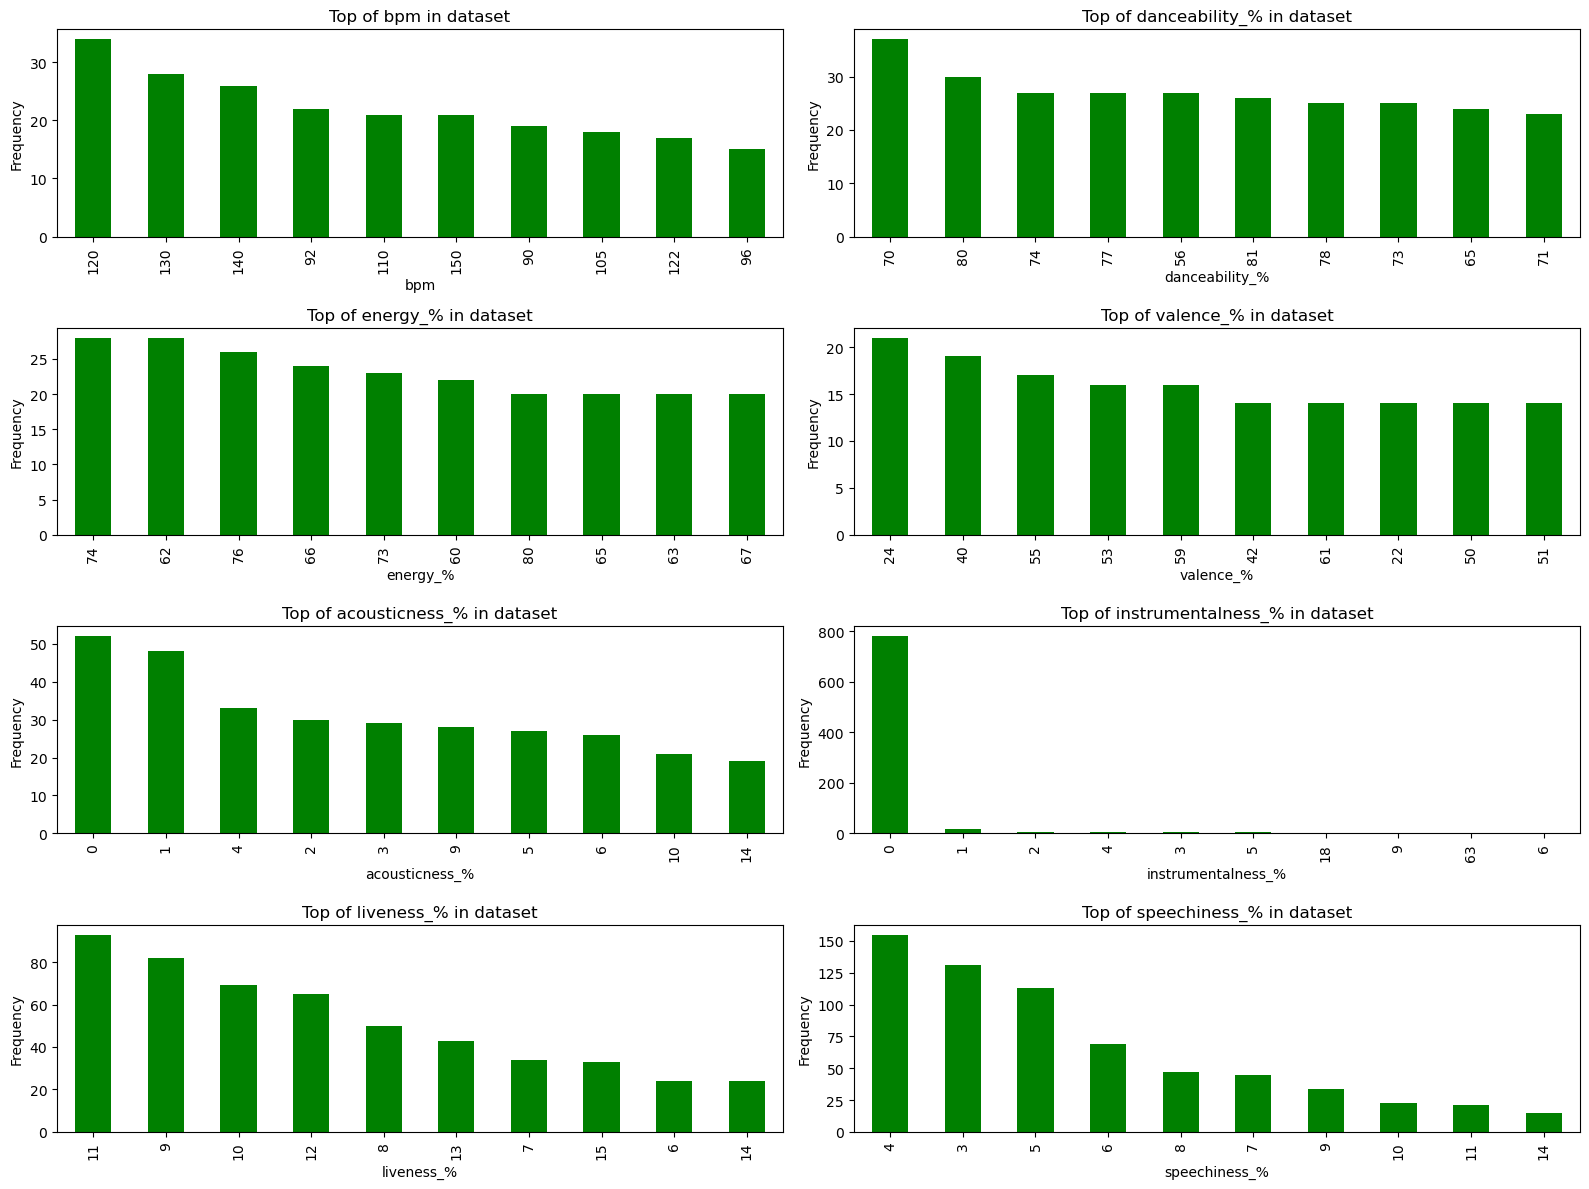

In [8]:
# top tune feature
plt.figure(figsize=(16, 12))
top_n = 10
for i, col in enumerate(tune, 1):
    plt.subplot(4, 2, i)
    data_count = data[col].value_counts()
    top_data = data_count.head(top_n)
    top_data.plot(kind='bar', color='green')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Top of {col} in dataset")
    plt.tight_layout()
plt.show()

In [9]:
# change data type to numeric
data['streams'] = pd.to_numeric(data['streams'], errors='coerce')
data['streams'] = data['streams'].fillna(0).astype(np.int64)

data['in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors='coerce')
data['in_deezer_playlists'] = data['in_deezer_playlists'].fillna(0).astype(np.int64)
data['in_shazam_charts'] = pd.to_numeric(data['in_shazam_charts'], errors='coerce')
data['in_shazam_charts'] = data['in_shazam_charts'].fillna(0).astype(np.int64)


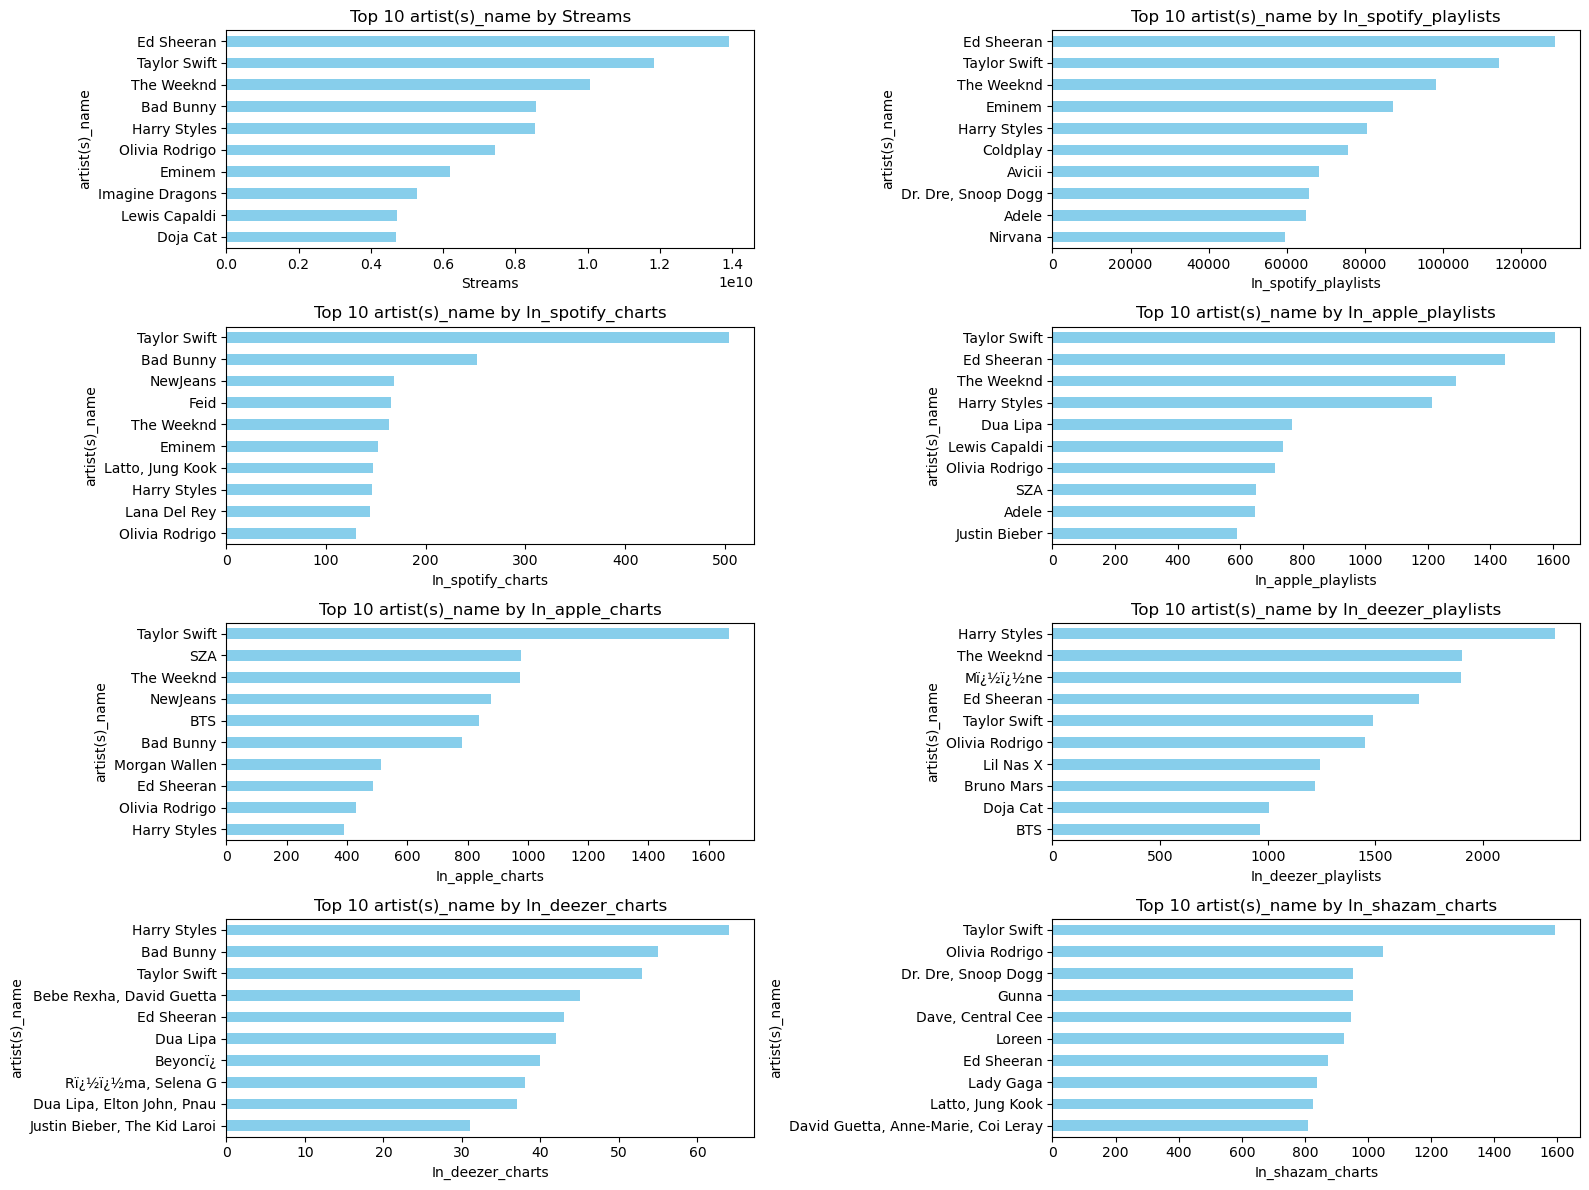

In [28]:
plt.figure(figsize=(16, 12))
groupby_col = 'artist(s)_name'

for i, col in enumerate(list_chart, 1):
    plt.subplot(4, 2, i)
    
    # sum list_chart by artist name and get the top 10
    data_sum = data.groupby(groupby_col)[col].sum()
    data_sorted = data_sum.sort_values(ascending=False).head(top_n)
 
    # Create a bar chart for the current column by artist_name
    data_sorted.plot(kind='barh', color='skyblue')
    plt.xlabel(col.capitalize())
    plt.ylabel(groupby_col)
    plt.title(f'Top 10 {groupby_col} by {col.capitalize()}')
    plt.gca().invert_yaxis()  # Reverse the order of artists
    plt.tight_layout()
plt.show()


In [23]:
# groupby_col would be categorial or object variables
groupby_col = 'artist(s)_name'
# calc_col would be numerical variables
calc_col = 'in_spotify_playlists'

# create a filtered data for Top 10 groupby_col
top_data = data.groupby([groupby_col])[calc_col].sum()

# Sort the groupby_col by the sum in descending order and select the top 10
data_sorted = top_data.sort_values(ascending=False).head(10)

# indexing to filter the original data based on the selected groupby_col
filtered_data = data[data[groupby_col].isin(data_sorted.index)]
filtered_data.shape

(85, 25)